# Proyek Akhir : Image Classification Model Deployment
Nama Lengkap : Muhammad Fadhil Abyansyah

Username : fadhil-abyansyah

Email : infofadhil29@gmail.com

## Import semua Library yang dibutuhkan

In [26]:
import os, zipfile, shutil, PIL.Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

## Ekstrak Dataset

In [27]:
local_zip = 'D:\Image-classification-deployment\cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('D:\Image-classification-deployment')
zip_ref.close()

## Deklarasi Direktori Dasar

In [28]:
BASE_DIR = 'D:\Image-classification-deployment\cell_images'

## Mengidentifikasi Jumlah File

In [44]:
def list_files(startpath):
    num_files = 0
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 2 * (level)
        num_files += len(files)
        print('{}{}/ {}'.format(indent, os.path.basename(root), (str(len(files)) + ' images' if len(files) > 0 else '')))

    return num_files

In [45]:
list_files(BASE_DIR)

cell_images/ 
  cell_images/ 
    Parasitized/ 13780 images
    Uninfected/ 13780 images
  Parasitized/ 13780 images
  Uninfected/ 13780 images


55120

## Membaca setiap file

In [55]:
def read_files(startpath):
    image_files = []
    for dirname, dirnames, filenames in os.walk(startpath):
        for filename in filenames:
            if filename.lower().endswith(('.jpg', '.png')):
                image_files.append(os.path.join(dirname, filename))

    return image_files

## Memastikan ukuran image yang beragam dengan fungsi PIL

In [56]:
full_dirs = read_files(BASE_DIR + "\cell_images")

image_sizes = []
for file in full_dirs:
    try:
        with PIL.Image.open(file) as image:
            width, height = image.size
            image_sizes.append(f'{width}x{height}')
    except Exception as e:
        print(f"Error processing {file}: {e}")

unique_sizes = set(image_sizes)

print(f'Size all images: {len(image_sizes)}')
print(f'Size unique images: {len(unique_sizes)}')
print(f'First 10 unique images: \n{list(unique_sizes)[:10]}')

Size all images: 27558
Size unique images: 1627
First 10 unique images: 
['130x175', '112x145', '82x97', '187x184', '136x127', '130x133', '85x97', '112x166', '166x226', '112x142']


## Augmentasi Data

In [58]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=0.2
)

## Pembuatan Generator untuk Data Pelatihan dan Data Validasi

In [60]:
training_generator = datagen.flow_from_directory(
    BASE_DIR + "\cell_images",
    subset='training',
    target_size=(120,120),
    seed=42,
    batch_size=64,
    interpolation='nearest',
    class_mode='binary',
    classes=['Parasitized','Uninfected']
)

validation_generator = datagen.flow_from_directory(
    BASE_DIR + "\cell_images",
    subset='validation',
    target_size=(120,120),
    seed=42,
    batch_size=64,
    interpolation='nearest',
    class_mode='binary',
    classes=['Parasitized','Uninfected']
)

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


## Pembuatan Model

In [61]:
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(120, 120, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.6),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Dropout(0.4),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 59, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 28, 28, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 128)      

## Callback untuk Menghentikan Pelatihan

In [66]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if((logs.get('accuracy') > 0.92) and (logs.get('val_accuracy') > 0.92)):
            self.model.stop_training = True
            print("\nAkurasi set pelatihan dan set validasi telah mencapai > 92%!")
callbacks = myCallback()

## Kompilasi dan Pelatihan Model

In [67]:
LR = 1e-4
model.compile(loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=LR),
    metrics=['accuracy'])

result = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=25,
    steps_per_epoch=100,
    validation_steps=35,
    callbacks=[callbacks],
    verbose=1
)

Epoch 1/25


100/100 [==============================] - 62s 600ms/step - loss: 0.6848 - accuracy: 0.5528 - val_loss: 0.6566 - val_accuracy: 0.7085
Epoch 2/25
100/100 [==============================] - 62s 621ms/step - loss: 0.6380 - accuracy: 0.6490 - val_loss: 0.6170 - val_accuracy: 0.6839
Epoch 3/25
100/100 [==============================] - 64s 641ms/step - loss: 0.6072 - accuracy: 0.6847 - val_loss: 0.5630 - val_accuracy: 0.7942
Epoch 4/25
100/100 [==============================] - 60s 600ms/step - loss: 0.5521 - accuracy: 0.7347 - val_loss: 0.5152 - val_accuracy: 0.8179
Epoch 5/25
100/100 [==============================] - 59s 589ms/step - loss: 0.4528 - accuracy: 0.7935 - val_loss: 0.3810 - val_accuracy: 0.8687
Epoch 6/25
100/100 [==============================] - 59s 587ms/step - loss: 0.3379 - accuracy: 0.8634 - val_loss: 0.3127 - val_accuracy: 0.9112
Epoch 7/25
100/100 [==============================] - 59s 586ms/step - loss: 0.2917 - accuracy: 0.8867 - val_loss: 0.2749 - val_

## Membuat plot terhadap akurasi model

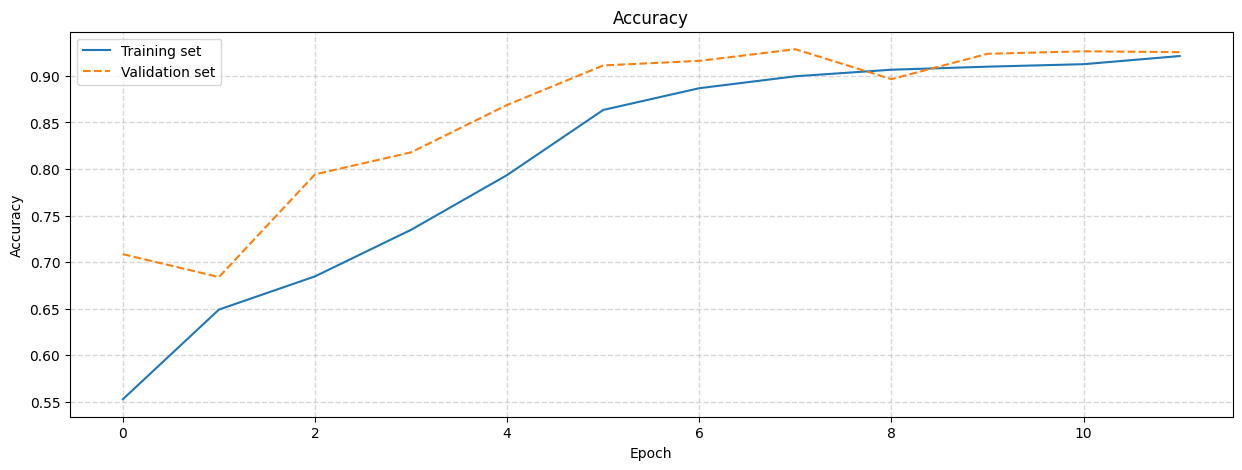

In [68]:
acc = result.history['accuracy']
val_acc = result.history['val_accuracy']
plt.figure(figsize=(15, 5))

plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training set')
plt.plot(val_acc, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)

plt.show()

## Membuat plot terhadap loss model

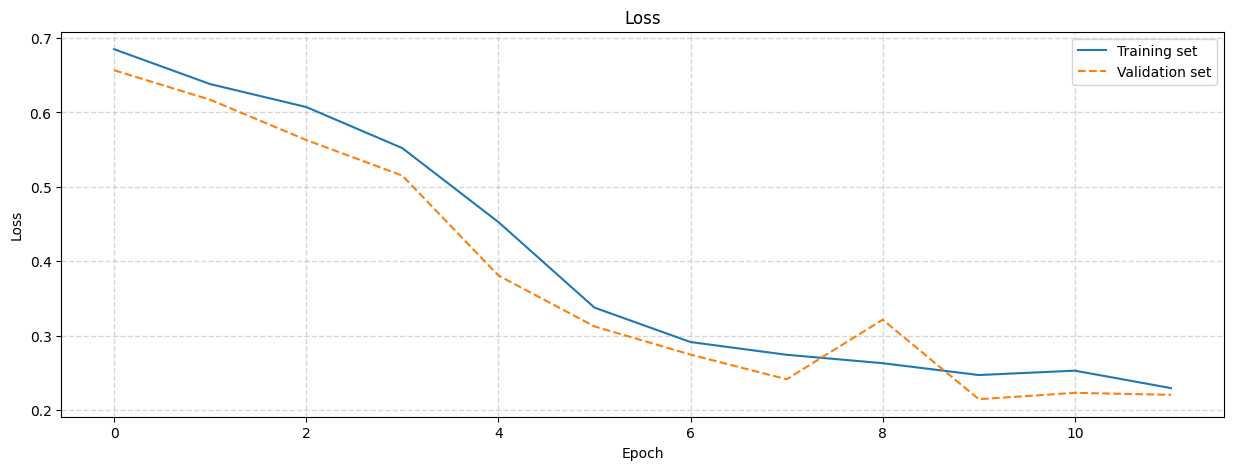

In [69]:
loss = result.history['loss']
val_loss = result.history['val_loss']
plt.figure(figsize=(15, 5))

plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Validation set', linestyle='--')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

## Menyimpan model ke dalam format TF-Lite

In [70]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\acer\AppData\Local\Temp\tmpwa_uzd4e\assets


INFO:tensorflow:Assets written to: C:\Users\acer\AppData\Local\Temp\tmpwa_uzd4e\assets


In [71]:
with tf.io.gfile.GFile('model__v1.tflite', 'wb') as f:
    f.write(tflite_model)